# Ocean Carrier Alliances Project - Analysis and Modeling

The initial model for the project inspects the effects of carrier alliances on frequency of service. We estimate this using the following equation:

$$ S_{lct} = b X_{lct} + a_1 AM_{ct}PC_{lc} + a_2 AM_{ct} + a_3 PC_{lc} + \epsilon_{lct} $$

where:
- $l$ is the lane, i.e. the departure port and arrival port pair
- $c$ is the carrier
- $t$ is the time period, which we aggregate to months (e.g., May 2019)
- $S$ is the frequency of service, i.e. the number of voyages provided to that lane by the carrier in the given month. 
- $X$ are the correction variables
- $AM$ is an indicator of whether or not the carrier is part of an alliance
- $PC$ is an indicator of whether or not the lane was serviced by that carrier before the alliance took effect. 

Since our initial interest is the impact of alliances on domestic producers, we start by analysing the exports database. 

## Data Import and Transformation

The data come from the PIERS database and are primarily processed in the [PIERS Data Project](https://github.com/epistemetrica/PIERS-Data-Project) with specific preparations for this analysis occuring in the 'oca_data_pred.ipynb' file in this repository. 

In [68]:
#preliminaries 
import pandas as pd #v2.1.3
import numpy as np
import polars as pl #v0.20.18
import plotly_express as px #v0.4.1 
import datetime as dt
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

#enable string cache for polars categoricals
pl.enable_string_cache()

#load data to lazyframe
exports_lf = pl.scan_parquet('data/exports/exports.parquet')
#ignore unused columns 
exports_lf = (
    exports_lf.select(
        'teus',
        #'carrier_name',
        #'carrier_scac',
        #'vessel_name',
        #'voyage_number',
        'vessel_id',
        'departure_port_code',
        'departure_port_name',
        #'coast_region', #note coast region was restricted to west coast in the data_prep nb
        'hs_code',
        #'date',
        #'dest_territory',
        #'dest_region',
        'arrival_port_code',
        'arrival_port_name',
        #'direction',
        'bol_id',
        'year',
        'month',
        'lane_id',
        'lane_name',
        'unified_carrier_name',
        'unified_carrier_scac',
        'vessel_lane_pair',
        'date_departure'
    )
)

### Cargo Sharing identification

NOTE: this step will be moved to oca_data_prep once established

We define the primary carrier for a given vessel as the carrier representing the most cargo carried on that ship during any given month. 

In [69]:
#assign primary carrier
def add_primary_carrier(lf):
    '''ad hoc function to find primary carrier for each vessel and indicate cargo sharing'''
    lf = (
        #sum teus over vessel, month, and carrier
        lf.with_columns(
            pl.col('teus').sum()
            .over('vessel_id', 'month', 'unified_carrier_scac')
            .alias('sum_teus')
            )
        #select carrier that moved the most cargo on that vessel during that month
        .with_columns(
            pl.col('unified_carrier_scac')
            .sort_by('sum_teus', descending=True)
            .drop_nulls().first()
            .over('vessel_id', 'month')
            .alias('vessel_owner')
            )
        #add bool col if bol is from primary carrier
        .with_columns(
            (pl.col('unified_carrier_scac')==pl.col('vessel_owner'))
            .alias('primary_cargo')
            )
        #set related columns to missing when vessel_id is missing
        .with_columns(
            pl.when(pl.col('vessel_id').is_null()).then(pl.lit(None)).otherwise(pl.col('vessel_owner')).alias('vessel_owner'),
            pl.when(pl.col('vessel_id').is_null()).then(pl.lit(None)).otherwise(pl.col('primary_cargo')).alias('primary_cargo')
        )
        #drop ad hoc sum_teus col
        .drop('sum_teus')
    )
    return lf

exports_lf = add_primary_carrier(exports_lf)

In [70]:
port_share_df = (
    exports_lf
    .group_by('departure_port_code')
    .agg(
        (pl.col('teus')*(1-pl.col('primary_cargo'))).sum().alias('sum_shared_teus'),
        pl.col('teus').sum().alias('sum_teus')
    )
    .with_columns((pl.col('sum_shared_teus')/pl.col('sum_teus')).alias('prop_shared'))
    .sort(by='sum_teus')
    .collect()
    .to_pandas()
)

In [71]:
px.scatter(port_share_df, x=port_share_df.index, y=port_share_df.prop_shared,
           color=port_share_df.departure_port_code,
           labels={'index':'Port Size Rank (ascending)'},
           title='Average % Shared Cargo by Port Size'
           )

/Users/adamwilson/miniconda3/envs/wsu/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [72]:
scipy.stats.pearsonr(port_share_df.sum_teus, port_share_df.prop_shared)

PearsonRResult(statistic=0.5545477796136669, pvalue=7.72422227465227e-05)

### Alliance Membership

Data on which carriers are part of which alliances was collected, where available, from alliance agreements filed with the Federal Maritime Commission. Where primary sources were not available, alliance membership was determined from industry reports and various media sources. 

In [73]:
#load alliance membership data from csv
alliances_df = pl.read_csv('data/misc/alliance_memberships.csv', dtypes={'scac':pl.Categorical, 'year':pl.Int32}).drop('carrier')
#alliances_df.head()

Since we are initially concerned with analysis based on whether or not a carrier was a member of an alliance, we unify the above into a single boolean column.

In [74]:
alliances_df = (
    alliances_df.with_columns(
        #set new 'alliance_member' column to 1 if the carrier is a member of any alliance
        pl.when((pl.col('2m') + pl.col('ocean') + pl.col('the'))>0)
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias('alliance_member')
    )
    #drop individual alliance columns
    .drop('2m', 'ocean', 'the')
)

### Visualizing volumes associated with alliances

In [75]:
port_alliance_df = (
    exports_lf.rename({'unified_carrier_scac':'scac'})
    .join(alliances_df.lazy(), on=['scac', 'year'], how='left')
    .group_by('departure_port_code', 'month')
    .agg(
        pl.col('teus').sum().alias('total_teus'),
        (pl.col('teus')*pl.col('alliance_member')).sum().alias('alliance_teus')
    )
    .with_columns(
        (pl.col('alliance_teus')/pl.col('total_teus')).alias('prop_alliance_teus')
    )
    .sort(by='month')
    .cast({'departure_port_code':pl.Utf8})
    .collect()
)

In [76]:
fig = px.line(
        data_frame=port_alliance_df.filter(
            pl.col('departure_port_code').is_in(
                port_alliance_df.group_by('departure_port_code').agg(pl.col('total_teus').sum()).sort(by='total_teus', descending=True).limit(10).to_series()
                )),
        x='month', y='prop_alliance_teus',
        color='departure_port_code',
        title= 'Proportion of volumes traded by alliance members over time'
    )
fig.show()

#### Sharing between Alliance Members

One potential effect of alliances is that shared capacity formerly available to all carriers becomes utilized mostly by alliance members, reducing the capacity for smaller carriers to move cargo on ships owned by major carriers. 

In [77]:
share_df = (
    exports_lf.rename({'unified_carrier_scac':'scac'})
    #join alliance membership
    .join(alliances_df.lazy(), on=['scac', 'year'], how='left')
    #get shared cargo col
    .with_columns(
        (pl.col('teus')*(1-pl.col('primary_cargo'))).alias('shared_teus')
    )
    .collect()
)

In [157]:
def sharing_by_carrier(lf, scac, carrier_name=None):
    '''
    ad hoc function to inspect sharing by scac over time for a given carrier
    inputs:
        scac - str - the SCAC for the carrier of interest
        carrier_name - str - the string name of the carrier of interest for plot title
    '''
    df = (
        #rename scac
        lf.rename({'unified_carrier_scac':'scac'})
        #join alliance membership
        .join(alliances_df.lazy(), on=['scac', 'year'], how='left')
        #get shared cargo col
        .with_columns((pl.col('teus')*(1-pl.col('primary_cargo'))).alias('shared_teus'))
        #only maersk vessels but not maersk cargo
        .filter((pl.col('vessel_owner')==scac)&(pl.col('scac')!=scac))
        #get percentages of other carriers
        .group_by('scac','month')
        .agg(pl.col('shared_teus').sum())
        .with_columns(pl.col('shared_teus').sum().over('month').alias('total_shared'))
        .with_columns((pl.col('shared_teus')/pl.col('total_shared')).alias('prop_shared'))
        #sort for plotting
        .sort(by=['month', 'scac'])
        #collect to dataframe and set dtypes
        .collect()
        #.with_columns(pl.col('month').str.to_datetime('%Y%m')) 
        .cast({'scac':pl.Utf8})
    )
    #plot
    fig = px.bar(df, x='month', y='prop_shared', color='scac', 
                color_discrete_sequence=px.colors.qualitative.Set3,
                title=str('Proportion of shared cargo on '+carrier_name+' ships by Carrier') if carrier_name else str('Proportion of shared cargo on '+scac+' ships by Carrier'),
                labels={
                    'prop_shared':'Percentage of Shared Cargo',
                    'month':'Time'
                })
    fig.show()

In [158]:
sharing_by_carrier(exports_lf, 'MSCU', 'Med Line')

In [152]:
sharing_by_carrier(exports_lf, 'MLSL', 'Maersk Line')

In [96]:
#get shared cargo percents from other carriers
df = (
    share_df
    #only maersk vessels but not maersk cargo
    .filter((pl.col('vessel_owner')=='MSCU')&(pl.col('scac')!='MSCU'))
    #get percentages of other carriers
    .group_by('scac','month')
    .agg(pl.col('shared_teus').sum())
    .with_columns(pl.col('shared_teus').sum().over('month').alias('total_shared'))
    .with_columns((pl.col('shared_teus')/pl.col('total_shared')).alias('prop_shared'))
    .sort(by=['month'])
)
#plot
px.bar(df.cast({'scac':pl.Utf8}), x='month', y='prop_shared', color='scac', 
       title='Proportion of shared cargo on Mediterranean ships by Carrier',
       labels={
           'prop_shared':'Percentage of Shared Cargo',
           'month':'Time'
       })

## Regression

In [10]:
#collect data into regular dataframe for analysis
df = (
    exports_lf
    #aggregate by lane, carrier, and month, counting unique departure dates to determine service frequency
    .group_by('lane_id', 'unified_carrier_scac', 'year', 'month')
    .agg(pl.col('date_departure').unique().count().alias('service_freq'))
    #rename carrier code column
    .rename({'unified_carrier_scac':'scac'})
    #cast data types
    .cast({'service_freq':pl.Int16})
    .with_columns(pl.col('month').str.to_datetime('%Y%m'))
    .collect()
)

#display
display(df.describe())
df.head()

statistic,lane_id,scac,year,month,service_freq
str,str,str,f64,str,f64
"""count""","""710650""","""710650""",710650.0,"""710650""",710650.0
"""null_count""","""0""","""0""",0.0,"""0""",0.0
"""mean""",null,null,2015.350219,"""2015-10-22 17:…",2.678755
"""std""",null,null,4.94651,null,1.940277
"""min""",null,null,2005.0,"""2005-01-01 00:…",1.0
"""25%""",null,null,2011.0,"""2011-12-01 00:…",1.0
"""50%""",null,null,2016.0,"""2016-06-01 00:…",2.0
"""75%""",null,null,2019.0,"""2019-12-01 00:…",4.0
"""max""",null,null,2023.0,"""2023-11-01 00:…",25.0


lane_id,scac,year,month,service_freq
cat,cat,i32,datetime[μs],i16
"""2704_55707""","""COSU""",2017,2017-09-01 00:00:00,1
"""2811_53827""","""OOLU""",2012,2012-04-01 00:00:00,1
"""2713_21951""","""SUDU""",2016,2016-08-01 00:00:00,2
"""2709_58886""","""NYKS""",2012,2012-08-01 00:00:00,4
"""2709_48931""","""HAPL""",2020,2020-04-01 00:00:00,1


In [11]:

#join alliance membership data into main df
df = (
    df.join(alliances_df, on=['scac', 'year'], how='left')
    #set missing alliance membership values to null 
    .with_columns(pl.col('alliance_member').fill_null(0))
)

In [12]:
df.head()

lane_id,scac,year,month,service_freq,alliance_member
cat,cat,i32,datetime[μs],i16,i32
"""2704_55707""","""COSU""",2017,2017-09-01 00:00:00,1,0
"""2811_53827""","""OOLU""",2012,2012-04-01 00:00:00,1,0
"""2713_21951""","""SUDU""",2016,2016-08-01 00:00:00,2,0
"""2709_58886""","""NYKS""",2012,2012-08-01 00:00:00,4,0
"""2709_48931""","""HAPL""",2020,2020-04-01 00:00:00,1,1


### Identifying whether a lane was serviced by that carrier before the alliance took effect

In [13]:
df= (
    #get total voyages prior to joining an alliance for each lane and carrier
    df.with_columns(
        pl.when(pl.col('alliance_member')==0)
        .then(pl.col('service_freq').sum().over('lane_id', 'scac'))
        .otherwise(pl.lit(0))
        .alias('service_prior')
    )
    #simplify to 1 if any service prior to alliance, 0 otherwise
    .with_columns(
        pl.when(pl.col('service_prior').sum()>0)
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .over('lane_id', 'scac')
        .alias('service_prior')
    )
)
df.head()

lane_id,scac,year,month,service_freq,alliance_member,service_prior
cat,cat,i32,datetime[μs],i16,i32,i32
"""2704_55707""","""COSU""",2017,2017-09-01 00:00:00,1,0,1
"""2811_53827""","""OOLU""",2012,2012-04-01 00:00:00,1,0,1
"""2713_21951""","""SUDU""",2016,2016-08-01 00:00:00,2,0,1
"""2709_58886""","""NYKS""",2012,2012-08-01 00:00:00,4,0,1
"""2709_48931""","""HAPL""",2020,2020-04-01 00:00:00,1,1,0


## Simple OLS Regression

Leaving out any correction variables for the moment, we estimate a simple OLS regression model on the equation above. 

In [14]:
#set dependent and independent variables
Y = df.select('service_freq').to_pandas()
X = (
    df.select('alliance_member', 'service_prior')
    .with_columns((pl.col('alliance_member')*pl.col('service_prior')).alias('alliance*prior'))
    .to_pandas()
)
#add intercept
X = sm.add_constant(X)
#instantiate model
model = sm.OLS(Y,X)
#run regression
results = model.fit()

#display
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           service_freq   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2377.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:56:14   Log-Likelihood:            -1.4759e+06
No. Observations:              710650   AIC:                         2.952e+06
Df Residuals:                  710646   BIC:                         2.952e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.462e+09    1.4e+09     -1.045      0.296    -4.2e+09    1.28e+09
alliance_member  1.462e+09    1.4e+09      1.045      0.296   -1.28e+09     4.2e+09
service_prior    1.462e+09    1.4e+09      1.045      0.296   -1.28e+09     4.2e+09
alliance*prior  -1.462e+09    1.4e+09     -1.045      0.296    -4.2e+09    1.28e+09
==============================================================================
Omnibus:                   253470.958   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1050462.971
Skew:                           1.739   Prob(JB):                         0.00
Kurtosis:                       7.835   Cond. No.                     1.73e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.76e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

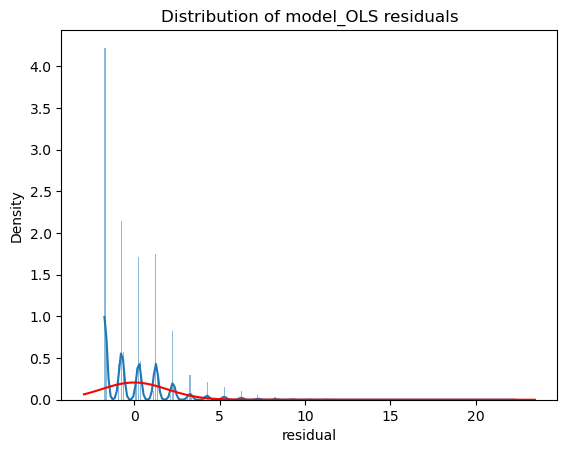

In [15]:
#obtain moments for residuals
mu, std = scipy.stats.norm.fit(results.resid)

#plot resid distribution
fig, ax = plt.subplots()
sns.histplot(x=results.resid, ax=ax, stat='density', linewidth=0, kde=True)
ax.set(title='Distribution of model_OLS residuals', xlabel='residual')

#add corresponding normal curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x,mu,std)
sns.lineplot(x=x, y=p, color='red', ax=ax)
plt.show()

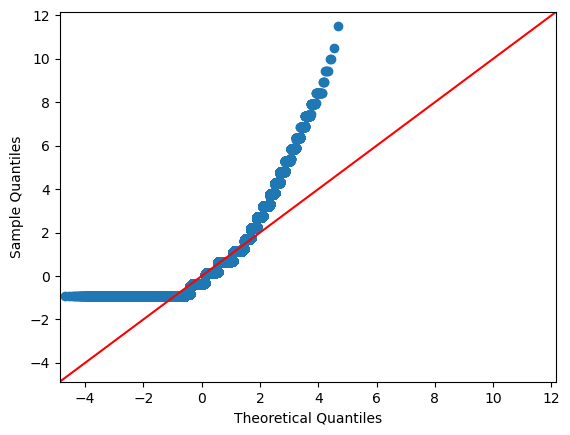

In [16]:
sm.qqplot(results.resid, line='45', fit=True);

### Limitations

1. It's broke. 
2. The simplistic method of identifying when a carrier had previously serviced that lane results in a uninteresting alliance*prior interaction term. We need to decide on a better means of identification. 
3. Complete alliance membership data only goes back to 2017; we need to update that table. 